# WiDS Datathon 2021

In [219]:
import os
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None)

* https://www.kaggle.com/c/widsdatathon2021/data?select=TrainingWiDS2021.csv
* https://he.wikipedia.org/wiki/%D7%A1%D7%95%D7%9B%D7%A8%D7%AA
* https://www.health.gov.il/PublicationsFiles/diabetes_registry_report_2019.pdf

## Overview
This year's challenge will focus on models to determine whether a patient admitted to an ICU has been diagnosed with a particular type of diabetes, Diabetes Mellitus. Using data from the first 24 hours of intensive care, individuals and teams will explore labeled training data for model development. Participants will then upload predictions for unlabeled data to Kaggle and these predictions will be used to determine the public leaderboard rankings, as well as the final leaderboard revealed at the close of the competition.

Data analysis can be completed using your preferred tools. Tutorials, sample code, and other resources will be posted throughout the competition at widsconference.org/datathon-resources and on the Kaggle Discussion Forum.

The WiDS Datathon 2021 dataset is similar to the WiDS Datathon 2020 dataset, but prior experience is not needed. This year's WiDS Datathon will also feature a Phase 2 hosted by the National Science Foundation Big Data Innovation Hubs, to encourage research papers and further collaboration. Special thanks to Kaggle for supporting the suite of WiDS Datathon cash awards this year, totaling $10,000 USD

## Evaluation
Submissions for the leaderboard will be evaluated on the Area under the Receiver Operating Characteristic (ROC) curve between the predicted and the observed target (diabetes_mellitus_diagnosis).

Learn more about AUC in this developer crash course, this video, or this Kaggle Learn Forum post.

Submission Format
For each encounter_id in the test dataset, you are asked to explore the columns of data (for example, patient laboratory results, demographics, and vital signs) and create a model that classifies whether the ICU patient has been diagnosed with Diabetes Mellitus.

A diabetes_mellitus value of 1 corresponds to a positive diagnosis (i.e., the patient has been diagnosed to have Diabetes Mellitus) and a value of 0 corresponds to a negative diagnosis.

# EDA

In [66]:
# C:\\Users\\liran\\OneDrive\\שולחן העבודה\\classification&clustering\\csv_files
os.chdir('user path')
os.getcwd()

'C:\\Users\\liran\\OneDrive\\שולחן העבודה\\classification&clustering\\csv_files'

In [67]:
df_diabetes = pd.read_csv('TrainingWiDS2021.csv', index_col=0)
df_diabetes.reset_index(drop=True, inplace=True)
df_dic = pd.read_csv('DataDictionaryWiDS2021.csv')
print(f'train shape: {df_diabetes.shape}, dic shape: {df_dic.shape}')

train shape: (130157, 180), dic shape: (181, 6)


## cleaning the data

In [68]:
def data_cleaning():
    df_diabetes['bmi'] = round(10000 * df_diabetes['weight'] / (df_diabetes['height'] ** 2), 8)
    mask_lst= []
    for i in range(len(df_diabetes)):
        mask_lst.append(round(10000*df_diabetes.weight[i] / (df_diabetes.height[i]**2), 
                              str(df_diabetes.bmi[i])[::-1].find('.')) == df_diabetes.bmi[i])
        
    threshold = 0.2
    col_to_be_drop = (df_diabetes.isnull().sum() / df_diabetes.shape[0] <= threshold) \
    [~(df_diabetes.isnull().sum() / df_diabetes.shape[0] <= threshold)].index
    print(f'number of columns to drop: {len(col_to_be_drop)}')
    df_diabetes.drop(columns=col_to_be_drop, inplace=True)
    print(f'train shape: {df_diabetes.shape}')
    
        # look at
    look_at_lst = ['d1_hco3_max', 'd1_hco3_max',  'd1_platelets_min', 'd1_platelets_max',  'd1_calcium_max',
     'd1_calcium_min', 'd1_hemaglobin_max','d1_hemaglobin_min','d1_potassium_min', 'h1_diasbp_noninvasive_min','h1_diasbp_noninvasive_max','h1_sysbp_noninvasive_min',
     'h1_sysbp_noninvasive_max','h1_spo2_max','h1_spo2_min', 'pre_icu_los_days']
    fintuning_drop = ['bun_apache','creatinine_apache','sodium_apache', 'd1_wbc_max','d1_wbc_min','d1_hematocrit_max',
     'd1_hematocrit_min','h1_mbp_noninvasive_min','h1_mbp_noninvasive_max','d1_creatinine_min',
     'd1_creatinine_max','d1_sodium_min','d1_sodium_max','temp_apache','h1_mbp_min','h1_mbp_max',
     'h1_resprate_max','h1_resprate_min','h1_diasbp_max','h1_diasbp_min','h1_sysbp_min','h1_sysbp_max','d1_temp_min',
     'd1_temp_max','h1_heartrate_max','h1_heartrate_min','weight','d1_mbp_noninvasive_min','d1_mbp_noninvasive_max','gcs_motor_apache',
     'gcs_eyes_apache','gcs_verbal_apache','height','d1_diasbp_noninvasive_min','d1_diasbp_noninvasive_max',
     'd1_sysbp_noninvasive_min','d1_sysbp_noninvasive_max','apache_3j_diagnosis','resprate_apache','gcs_unable_apache',
     'd1_resprate_min','d1_resprate_max','d1_spo2_min','d1_spo2_max','map_apache','d1_mbp_max','d1_mbp_min',
     'heart_rate_apache','d1_diasbp_max','d1_diasbp_min','d1_sysbp_min','d1_sysbp_max','d1_heartrate_max','d1_heartrate_min',
     'icu_admit_source','aids','cirrhosis','hepatic_failure','immunosuppression',
     'leukemia','lymphoma','solid_tumor_with_metastasis','encounter_id','hospital_id','ventilated_apache','intubated_apache',
     'arf_apache','apache_post_operative','readmission_status','icu_stay_type','icu_id','elective_surgery','glucose_apache','d1_hco3_min']
    fintuning_drop = fintuning_drop + look_at_lst

    #stay
    stay_lst = ['d1_glucose_max','d1_glucose_min','age','bmi','apache_2_diagnosis', 'ethnicity', 'gender',
     'icu_type', 'diabetes_mellitus', 'd1_bun_max',  'd1_potassium_max']
    
    print(f'number of columns to drop: {len(fintuning_drop)}')
    df_diabetes.drop(columns=fintuning_drop, inplace=True)
    print(f'train shape: {df_diabetes.shape}')
    print(df_diabetes.shape)
    df_diabetes.loc[df_diabetes.ethnicity.isnull(),'ethnicity'] = 'Other/Unknown'
    df_diabetes.dropna(inplace=True)
    print(df_diabetes.shape)
    
    glucos_min = df_diabetes[df_diabetes['d1_glucose_max'] < df_diabetes['d1_glucose_min']]['d1_glucose_min'].values[0]
    glucose_index = df_diabetes[df_diabetes['d1_glucose_max'] < df_diabetes['d1_glucose_min']]['d1_glucose_min'].index
    glucos_max = df_diabetes.loc[glucose_index, 'd1_glucose_max'].values[0]
    df_diabetes.loc[glucose_index, 'd1_glucose_min'] = glucos_max
    df_diabetes.loc[glucose_index, 'd1_glucose_max'] = glucos_min
    
    bun_min = df_diabetes[df_diabetes['d1_bun_max'] < df_diabetes['d1_bun_min']]['d1_bun_min'].values
    bun_index = df_diabetes[df_diabetes['d1_bun_max'] < df_diabetes['d1_bun_min']]['d1_bun_min'].index
    bun_max = df_diabetes.loc[bun_index, 'd1_bun_max'].values
    df_diabetes.loc[bun_index, 'd1_bun_min'] = bun_max
    df_diabetes.loc[bun_index, 'd1_bun_max'] = bun_min

In [69]:
data_cleaning()

number of columns to drop: 79
train shape: (130157, 101)
number of columns to drop: 90
train shape: (130157, 12)
(130157, 12)
(106667, 12)


In [70]:
df_diabetes.isnull().sum()

age                   0
bmi                   0
ethnicity             0
gender                0
icu_type              0
apache_2_diagnosis    0
d1_bun_max            0
d1_bun_min            0
d1_glucose_max        0
d1_glucose_min        0
d1_potassium_max      0
diabetes_mellitus     0
dtype: int64

## imbalanced data

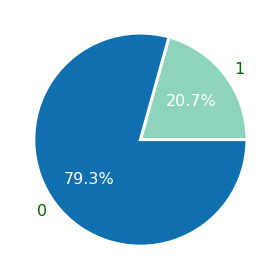

In [253]:
cmap = plt.get_cmap('GnBu')
x = df_diabetes['diabetes_mellitus'].value_counts(normalize=True).sort_index(ascending = False)
colors = list(cmap(np.linspace(0.45, 0.85, len(x))))
labels = df_diabetes['diabetes_mellitus'].unique()
fig, ax = plt.subplots()
patches, texts, pcts = ax.pie(x, labels=labels,autopct='%.1f%%',colors=colors, wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'})
plt.setp(pcts, color='white',fontsize = 16)
plt.setp(texts, fontsize = 16,color = 'darkgreen')
plt.tight_layout()

## mapping categorial columns

### APACHE

In [72]:
g = df_diabetes.groupby(['apache_2_diagnosis']).agg(pct_diabetes=pd.NamedAgg(column="diabetes_mellitus", aggfunc=lambda x: 100*(x.sum() / len(x))),
                                         num_of_patients=pd.NamedAgg(column="diabetes_mellitus", aggfunc=lambda x: len(x))).copy()
g.sort_values(by='pct_diabetes', inplace=True)
apache_code = g.index
pct_diabetes = g.pct_diabetes.values.round(2)
apache_dic = dict(zip(apache_code, pct_diabetes))
df_diabetes['apache_2_diagnosis'] = df_diabetes['apache_2_diagnosis'].map(apache_dic)
df_diabetes.loc[df_diabetes['apache_2_diagnosis']<8, 'apache_2_diagnosis'] = 1
df_diabetes.loc[df_diabetes['apache_2_diagnosis']>=35, 'apache_2_diagnosis'] = 6
apache_seg = [8,14,19,26,35]
for i in range(len(apache_seg)-1):
    df_diabetes.loc[(df_diabetes['apache_2_diagnosis']>=apache_seg[i])&(df_diabetes['apache_2_diagnosis']<apache_seg[i+1]), 'apache_2_diagnosis'] = i+2
df_diabetes.apache_2_diagnosis.value_counts()

4.0    62647
5.0    16589
3.0    11204
2.0     9320
1.0     4139
6.0     2768
Name: apache_2_diagnosis, dtype: int64

### ethnicity & icu_type

In [73]:
def map_categorial(col_name):
    g = df_diabetes.groupby([col_name]).agg(pct_diabetes=pd.NamedAgg(column="diabetes_mellitus", aggfunc=lambda x: 100*(x.sum() / len(x))),
                                             num_of_patients=pd.NamedAgg(column="diabetes_mellitus", aggfunc=lambda x: len(x))).copy()
    g.sort_values(by='pct_diabetes', inplace=True)
    map_dic = dict(zip(g.index, list(range(1, len(g)+1))))
    df_diabetes[col_name] = df_diabetes[col_name].map(map_dic)

In [74]:
map_categorial('ethnicity')
map_categorial('icu_type')

## outliers

In [75]:
# sns.pairplot(data=df_diabetes)

In [76]:
def data_cleaning_outliers(df_diabetes):
    print(df_diabetes.shape)
    # removing age = 0.0 
    df_diabetes = df_diabetes[~(df_diabetes['age']==0)]
    # claening with Z value
    numeric_col = list(df_diabetes.select_dtypes(include=['float64', 'int64']).columns)
    numeric_col.remove('apache_2_diagnosis')
    numeric_col.remove('age')
    numeric_col.remove('diabetes_mellitus')
    df_diabetes = df_diabetes[(np.abs(sc.stats.zscore(df_diabetes[numeric_col])) < 3).all(axis=1)]

    # another option of cleaning is with IQR value
    # Q1 = df_diabetes[numeric_col_remove_from].quantile(0.25)
    # Q3 = df_diabetes[numeric_col_remove_from].quantile(0.75)
    # IQR = Q3 - Q1
    # len(df_diabetes) - len(df_diabetes[((df_diabetes[numeric_col_remove_from] >= (Q1 - 1.5 * IQR)) & (df_diabetes[numeric_col_remove_from] <= (Q3 + 1.5 * IQR))).all(axis=1)])

    print(df_diabetes.shape)
    return df_diabetes.copy()

In [77]:
df_diabetes = data_cleaning_outliers(df_diabetes)

(106667, 12)
(96408, 12)


# feature selecting

## PCA

In [78]:
# performing pca on min column
def data_pca_trans():
    pca_transformer = PCA(n_components=2)
    X = df_diabetes[['d1_bun_min','d1_glucose_min']].copy()
    diabetes_pca_transformer = pca_transformer.fit(X)
    diabetes_pca = diabetes_pca_transformer.transform(X)
    print(f'min columns pca variance: {diabetes_pca_transformer.explained_variance_ratio_.cumsum()}')
    # according to the results (95% variance threshold) we decide not converting those columns
    pca_transformer = PCA(n_components=3)
    X = df_diabetes[['d1_bun_max','d1_glucose_max', 'd1_potassium_max']].copy()
    diabetes_pca_transformer = pca_transformer.fit(X)
    diabetes_pca = diabetes_pca_transformer.transform(X)
    print(f'max columns pca variance: {diabetes_pca_transformer.explained_variance_ratio_.cumsum()}')
    df_diabetes_pca = df_diabetes.copy()
    df_diabetes_pca.drop(columns=['d1_bun_max','d1_glucose_max', 'd1_potassium_max'], axis=1, inplace=True)
    df_diabetes_pca['d1_max_pca'] = diabetes_pca[:, 0]
    return df_diabetes_pca.copy()
    # according to the results (95% variance threshold) we decide to converting the three max column to one column

In [79]:
df_diabetes_pca = data_pca_trans()

min columns pca variance: [0.83647954 1.        ]
max columns pca variance: [0.95339978 0.99993621 1.        ]


## selectkbest

In [80]:
def data_kbest_trans():
    col_select = ['d1_bun_max','d1_glucose_max', 'd1_potassium_max', 'd1_bun_min','d1_glucose_min']
    df_diabetes_kbest = df_diabetes.copy()
    df_diabetes_kbest.drop(columns=col_select, axis=1, inplace=True)
    df_2_col = SelectKBest(f_classif, k=2).fit_transform(df_diabetes[col_select], df_diabetes['diabetes_mellitus'])
    df_diabetes_kbest['d1_1_select'] = df_2_col[:,0]
    df_diabetes_kbest['d1_2_select'] = df_2_col[:,1]
    return df_diabetes_kbest

In [81]:
df_diabetes_kbest = data_kbest_trans()

## columns variance

In [84]:
# checking variance of columns
df_diabetes_numeric = df_diabetes.select_dtypes(include=[np.number])
selector = VarianceThreshold(0)
selector.fit(df_diabetes_numeric)
print(f'number of columns that not change: {len(df_diabetes_numeric.columns) - sum(selector.get_support())}')
df_diabetes_cat = df_diabetes.select_dtypes(exclude=[np.number])
df_diabetes_cat.nunique()

number of columns that not change: 0


gender    2
dtype: int64

## get dummies

In [239]:
df_model_pca = df_diabetes_pca.copy()
df_model_pca = pd.get_dummies(df_model_pca)
df_model_kbest = df_diabetes_kbest.copy()
df_model_kbest = pd.get_dummies(df_model_kbest)

# Execution of models - PCA

In [256]:
X = df_model_pca.drop(columns=['diabetes_mellitus'],axis=1)
y = df_model_pca['diabetes_mellitus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
k = 3
sss = StratifiedShuffleSplit(n_splits=k, test_size=0.2, random_state=0)

In [257]:
def cross_val(clf, clf_model_name):
    scores = cross_val_score(clf, X_train, y_train, cv=sss, scoring='roc_auc')
    print("Scores ",clf_model_name,": " + (k * "{:.3f} ").format(*scores))

In [258]:
def plot_auc(clf, clf_model_name):
    scores_auc = clf.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, scores_auc, pos_label=1)
    res = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds})
    auc_score = round(roc_auc_score(y_test==1, scores_auc), 3)
    plt.plot(fpr, tpr, 'k--',linewidth=2)
    plt.fill_between(fpr, tpr, color='lightskyblue')
    plt.title(f'ROC of {clf_model_name}')
    plt.text(0.5, 0.5, f'AUC {auc_score}', size=15)
    plt.xlabel('FPR (False Positive Rate = 1-specificity)')
    plt.ylabel('TPR (True Positive Rate = sensitivity)')
    plt.xlim([0, 1])
    plt.ylim([0, 1])

## Random Forest

In [155]:
# gread search
my_param_grid = {'n_estimators':[50, 100, 150], 'criterion':['gini', 'entropy'], 'max_depth':[10, 15, 20]}
clf = RandomForestClassifier(random_state=1)
clf_gs = GridSearchCV(clf, my_param_grid, cv=sss)
clf_gs.fit(X_train, y_train)
print("Best parameters:", clf_gs.best_params_)

Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 50}


Scores  RandomForest : 0.822 0.826 0.826 


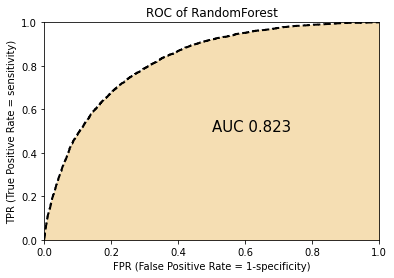

In [233]:
clf = RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=50)
clf.fit(X_train, y_train)
cross_val(clf, 'RandomForest')
plot_auc(clf, 'RandomForest')

## Bagging of Random Forest

In [194]:
clf_bagging = BaggingClassifier(base_estimator=clf)
clf_bagging.fit(X_train, y_train)

BaggingClassifier(base_estimator=RandomForestClassifier(criterion='entropy',
                                                        max_depth=10,
                                                        n_estimators=50))

Scores  BaggingRandomForest : 0.827 0.830 0.831 


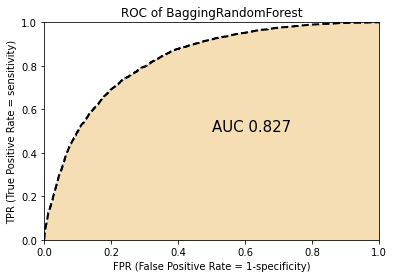

In [196]:
cross_val(clf_bagging, 'BaggingRandomForest')
plot_auc(clf_bagging, 'BaggingRandomForest')

## Ada boost

In [201]:
# gread search
my_param_grid = {'n_estimators':[100, 150, 200, 250], 'learning_rate':[0.005, 0.01, 0.015]}
clf_base = DecisionTreeClassifier(max_depth=3)
clf_adaboost = AdaBoostClassifier(base_estimator=clf_base)
clf_gs = GridSearchCV(clf_adaboost, my_param_grid, cv=sss)
clf_gs.fit(X_train, y_train)
print("Best parameters:", clf_gs.best_params_)

Best parameters: {'learning_rate': 0.015, 'n_estimators': 250}


Scores  Ada boost : 0.822 0.827 0.825 


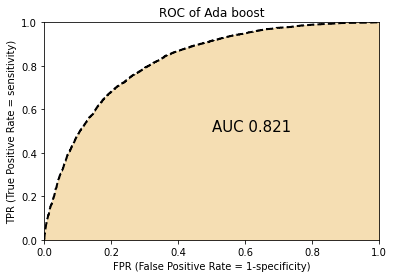

In [202]:
clf = AdaBoostClassifier(base_estimator=clf_base, learning_rate=0.015, n_estimators=250)
clf.fit(X_train, y_train)
cross_val(clf, 'Ada boost')
plot_auc(clf, 'Ada boost')

## XGBoost

In [215]:
# gread search
my_param_grid = {'n_estimators':[100, 150, 200], 'learning_rate':[0.005, 0.01], 'max_depth':[10, 15], 'eval_metric':['auc']}
clf = XGBClassifier()
clf_gs = GridSearchCV(clf, my_param_grid, cv=sss)
clf_gs.fit(X_train, y_train)
print("Best parameters:", clf_gs.best_params_)

Best parameters: {'eval_metric': 'auc', 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200}


Scores  XGBClassifier : 0.820 0.825 0.826 


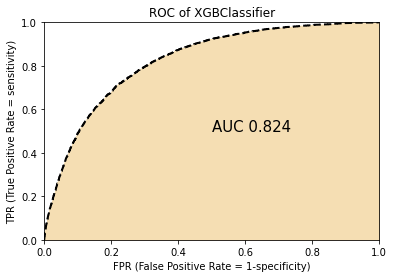

In [217]:
clf = XGBClassifier(max_depth=10, learning_rate=0.01, n_estimators=200, eval_metric='auc')
clf.fit(X_train, y_train)
cross_val(clf, 'XGBClassifier')
plot_auc(clf, 'XGBClassifier')

## LightGBM

In [234]:
# gread search
my_param_grid = {'n_estimators':[100, 150, 200], 'learning_rate':[0.005, 0.01], 'max_depth':[10, 15], 'metric':['auc']}
clf = LGBMClassifier()
clf_gs = GridSearchCV(clf, my_param_grid, cv=sss)
clf_gs.fit(X_train, y_train)
print("Best parameters:", clf_gs.best_params_)

Best parameters: {'learning_rate': 0.01, 'max_depth': 10, 'metric': 'auc', 'n_estimators': 200}


Scores  LGBMClassifier : 0.825 0.829 0.828 


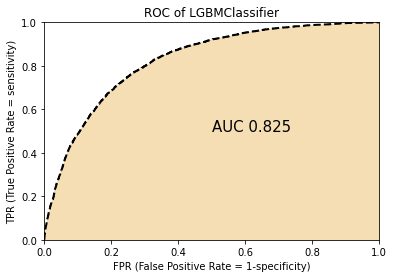

In [235]:
clf = LGBMClassifier(max_depth=10, learning_rate=0.01, n_estimators=200, metric='auc')
clf.fit(X_train, y_train)
cross_val(clf, 'LGBMClassifier')
plot_auc(clf, 'LGBMClassifier')

## Voting

In [259]:
clf1 = BaggingClassifier(base_estimator=RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=50))
clf2 = XGBClassifier(max_depth=10, learning_rate=0.01, n_estimators=200, eval_metric='auc')
clf3 = LGBMClassifier(max_depth=10, learning_rate=0.01, n_estimators=200, metric='auc')

classifiers = [('BC', clf1), ('XGB', clf2), ('LGBM', clf3)]
clf_voting = VotingClassifier(estimators=classifiers, voting='soft')
clf_voting.fit(X_train, y_train)

VotingClassifier(estimators=[('BC',
                              BaggingClassifier(base_estimator=RandomForestClassifier(criterion='entropy',
                                                                                      max_depth=10,
                                                                                      n_estimators=50))),
                             ('XGB',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            enable_categorical=False,
                                            eval_metric='auc', gamma=None,
                                            gpu_id=None, importance_type=None,
                                            int...
                                            min_child_weight=N

Scores  Voting : 0.826 0.831 0.831 


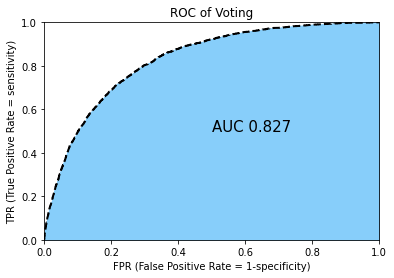

In [260]:
cross_val(clf_voting, 'Voting')
plot_auc(clf_voting, 'Voting')

# Execution of models - selectkbest

In [241]:
X = df_model_kbest.drop(columns=['diabetes_mellitus'],axis=1)
y = df_model_kbest['diabetes_mellitus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
k = 3
sss = StratifiedShuffleSplit(n_splits=k, test_size=0.2, random_state=0)

## Random Forest

Scores  RandomForest : 0.820 0.823 0.822 


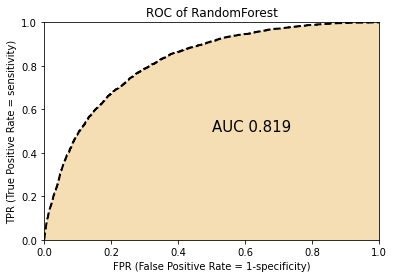

In [242]:
clf = RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=50)
clf.fit(X_train, y_train)
cross_val(clf, 'RandomForest')
plot_auc(clf, 'RandomForest')

## Bagging of Random Forest

In [243]:
clf_bagging = BaggingClassifier(base_estimator=clf)
clf_bagging.fit(X_train, y_train)

BaggingClassifier(base_estimator=RandomForestClassifier(criterion='entropy',
                                                        max_depth=10,
                                                        n_estimators=50))

Scores  BaggingRandomForest : 0.821 0.825 0.824 


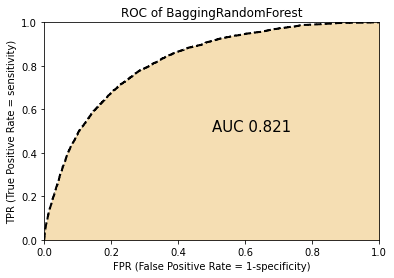

In [244]:
cross_val(clf_bagging, 'BaggingRandomForest')
plot_auc(clf_bagging, 'BaggingRandomForest')

## Ada boost

Scores  Ada boost : 0.817 0.822 0.820 


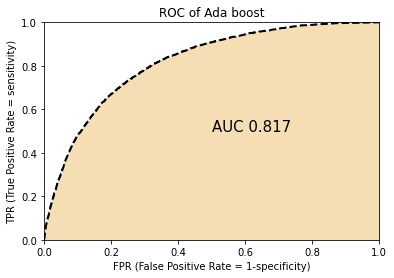

In [245]:
clf = AdaBoostClassifier(base_estimator=clf_base, learning_rate=0.015, n_estimators=250)
clf.fit(X_train, y_train)
cross_val(clf, 'Ada boost')
plot_auc(clf, 'Ada boost')

## XGBoost

Scores  XGBClassifier : 0.815 0.818 0.818 


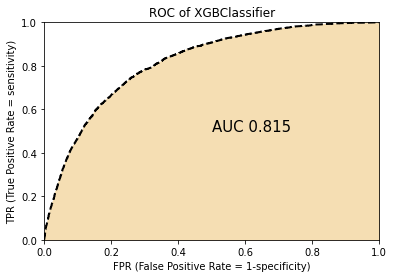

In [246]:
clf = XGBClassifier(max_depth=10, learning_rate=0.01, n_estimators=200, eval_metric='auc')
clf.fit(X_train, y_train)
cross_val(clf, 'XGBClassifier')
plot_auc(clf, 'XGBClassifier')

## LightGBM

Scores  LGBMClassifier : 0.818 0.823 0.821 


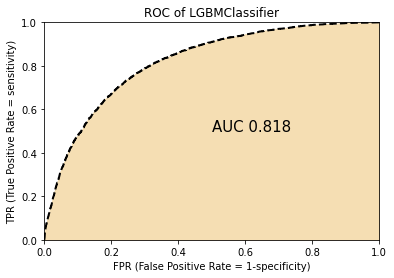

In [247]:
clf = LGBMClassifier(max_depth=10, learning_rate=0.01, n_estimators=200, metric='auc')
clf.fit(X_train, y_train)
cross_val(clf, 'LGBMClassifier')
plot_auc(clf, 'LGBMClassifier')

## Voting

In [248]:
clf1 = BaggingClassifier(base_estimator=RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=50))
clf2 = RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=50)
clf3 = LGBMClassifier(max_depth=10, learning_rate=0.01, n_estimators=200, metric='auc')

classifiers = [('BC', clf1), ('RF', clf2), ('LGBM', clf3)]
clf_voting = VotingClassifier(estimators=classifiers, voting='soft')
clf_voting.fit(X_train, y_train)

VotingClassifier(estimators=[('BC',
                              BaggingClassifier(base_estimator=RandomForestClassifier(criterion='entropy',
                                                                                      max_depth=10,
                                                                                      n_estimators=50))),
                             ('RF',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=10,
                                                     n_estimators=50)),
                             ('LGBM',
                              LGBMClassifier(learning_rate=0.01, max_depth=10,
                                             metric='auc', n_estimators=200))],
                 voting='soft')

Scores  Voting : 0.821 0.824 0.824 


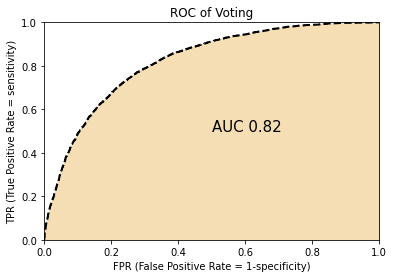

In [249]:
cross_val(clf_voting, 'Voting')
plot_auc(clf_voting, 'Voting')

# permutation importance

In [158]:
perm = PermutationImportance(clf, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0452 ± 0.0005,d1_max_pca
0.0089 ± 0.0020,apache_2_diagnosis
0.0065 ± 0.0012,bmi
0.0025 ± 0.0020,age
0.0020 ± 0.0012,d1_glucose_min
0.0017 ± 0.0008,d1_bun_min
0.0005 ± 0.0005,gender_M
0.0004 ± 0.0010,icu_type
0.0003 ± 0.0007,ethnicity
0.0000 ± 0.0006,gender_F
